In [1]:
# Sam Brown
# sam_brown@mines.edu
# July 17
# Goal: Tune lstm model and produce interesting graphs regarding the nature of the lstms for our problem

import sys
sys.path.append("/Users/sambrown04/Documents/SURF/whillans-surf/notebooks/SURF")

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from models.slip_lstm import SlipLSTM

df = pd.read_csv("/Users/sambrown04/Documents/SURF/Preproc_data/10-18.csv", parse_dates=["start_time"])
df = df.iloc[500:3000] # NANS UNKNOWN CHECK AGAIN

In [2]:
# Features and Target
X = df[['tide_height', 'tide_deriv', 'A_diurn', 'A_semidiurn', 'high_t_evt', 'time_since', 'sev_stds', 'pre-s_stds', 'form_fac']]
y = df['slip_size_standardized'].values.reshape(-1,1)

# Normalize features
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

In [3]:
def gen_sequences(X, y, seq_len):
    sequences = []
    targets = []

    for i in range(len(X) - seq_len):
        seq = X[i:i+seq_len]
        target = y[i+seq_len - 1][0] # Including the features of the last event when predicting last event slip size 
        sequences.append(seq)
        targets.append(target)

    X_seq = torch.tensor(np.array(sequences), dtype=torch.float32)
    y_seq = torch.tensor(np.array(targets), dtype=torch.float32).unsqueeze(1)

    return X_seq, y_seq

In [6]:
seq_lengths = range(1, 30, 1)
results = []

for seq_len in seq_lengths:

    print(f"running model for seq length {seq_len}")

    X_seq, y_seq = gen_sequences(X_scaled, y_scaled, seq_len)

    # Split into train and test
    X_train, X_val, y_train, y_val = train_test_split(
        X_seq, y_seq, test_size=0.2, shuffle=False  # no shuffle = time-aware
    )

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

    model = SlipLSTM(input_size=X_seq.shape[2], hidden_size=64)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(30):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

    val_preds  = []
    val_targets = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            val_preds.append(model(xb).cpu())
            val_targets.append(yb.cpu())

        # Combine batches into single tensors
        val_preds = torch.cat(val_preds, dim=0).squeeze().numpy()
        val_targets = torch.cat(val_targets, dim=0).squeeze().numpy()

        # Metrics
        val_loss = loss_fn(torch.tensor(val_preds), torch.tensor(val_targets)).item()
        r2 = r2_score(val_targets, val_preds)
        results.append(r2)
            
    print(f"Final MSE for SEQ_LEN={seq_len}: {val_loss:.4f} \n R2 = {r2:.4f}")

running model for seq length 1
Final MSE for SEQ_LEN=1: 0.5054 
 R2 = 0.5042
running model for seq length 2
Final MSE for SEQ_LEN=2: 0.5210 
 R2 = 0.4888
running model for seq length 3
Final MSE for SEQ_LEN=3: 0.4966 
 R2 = 0.5128
running model for seq length 4
Final MSE for SEQ_LEN=4: 0.6203 
 R2 = 0.3914
running model for seq length 5
Final MSE for SEQ_LEN=5: 0.6067 
 R2 = 0.4034
running model for seq length 6
Final MSE for SEQ_LEN=6: 0.5355 
 R2 = 0.4734
running model for seq length 7
Final MSE for SEQ_LEN=7: 0.4710 
 R2 = 0.5369
running model for seq length 8
Final MSE for SEQ_LEN=8: 0.4821 
 R2 = 0.5260
running model for seq length 9
Final MSE for SEQ_LEN=9: 0.5306 
 R2 = 0.4783
running model for seq length 10
Final MSE for SEQ_LEN=10: 0.4402 
 R2 = 0.5667
running model for seq length 11
Final MSE for SEQ_LEN=11: 0.5202 
 R2 = 0.4880
running model for seq length 12
Final MSE for SEQ_LEN=12: 0.5358 
 R2 = 0.4726
running model for seq length 13
Final MSE for SEQ_LEN=13: 0.5150 
 R2 

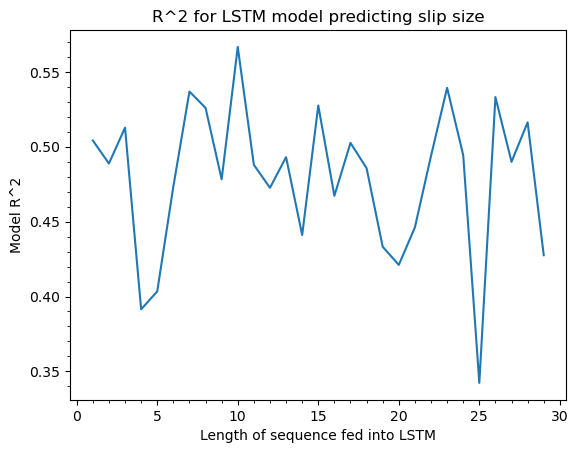

In [15]:
plt.plot(seq_lengths, results)
plt.xlabel("Length of sequence fed into LSTM")
plt.ylabel("Model R^2")
plt.title("R^2 for LSTM model predicting slip size")
plt.minorticks_on()